<a href="https://colab.research.google.com/github/kdmalc/intro-computer-vision/blob/main/HW4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Kai Malcolm

NetID: km82

Collaborators: NA

## General instructions
Please copy this colab notebook into your own Drive to edit. This notebook will also serve as your final submission report - please ensure that code cells run correctly, and that all non-code (text/latex) blocks are rendered correctly before submissing the file. Feel free to add any additional cells (code or text) you need. Please follow good coding, markdown, and presentation etiquette.

__Please do not use any AI tools for this assignment.__


## Submission instructions

- Before submitting, please `run-all` the code. This will re-render your entire jupyter file cell by cell to produce all the outputs.

- You are required to download the colab notebook as a `.ipynb` file and submit it to canvas. Please name your `.ipynb` file as `netid.ipynb`

- Modify the text cell on top to include your name and the names of any collaborators from this class you worked with on this assignment.

- Download a pdf of the executed colab notebook. You can use print -> save as pdf. Please name your `.pdf` file as `netid.pdf`.

- Any extra images used in the homework should also be uploaded to canvas.

- For simplicity, you can also upload a `netid.zip` file to canvas containing all solution files.

In [1]:
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms as T

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Problem 1

### Problem 1.1: Basics of Autograd

In [3]:
"""
Taylor approximation to sin(x).
x: (Tensor[float]) input value(s)
n: (int) number of terms in Taylor approximation

Output:
(Tensor[float]) Taylor approximation to sin(x)
"""
def sin_taylor(x, n=10):
  # f(x) ~ \sum f^n(a)/(n!) * (x-a)^n
  # Let a = 0 (assuming we are evaluating at 0)
  # f(x) is just sin(x)
  # n is the number of terms to use in the approx
  result = 0
  for k in range(n):
      sign = 1 if k % 4 != 3 else -1
      if k%2==0:
          deriv = np.sin(0)
      else:
          deriv = np.cos(0)
      #print(f"k: {k}; sign: {sign}, deriv: {deriv}")
      term = sign * deriv / math.factorial(k) * (x ** k)
      result += term
  return result

In [4]:
print(sin_taylor(np.pi / 2, 10))  # Should be close to 1

1.0000035425842861


In [5]:
# 1b

x = torch.tensor(np.pi / 4, dtype=torch.float64, requires_grad=True)
y = sin_taylor(x, 10)
# Use autograd to compute dy/dx
y.backward()

# Compare to exact derivative: cos(π/4)
print("My taylor approx answer:", y.item())
print("Autograd answer:", x.grad.item())
print("Gruond truth:", np.cos(math.pi/4))


My taylor approx answer: 0.7071067829368671
Autograd answer: 0.7071068056832943
Gruond truth: 0.7071067811865476


In [6]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


False
No GPU


In [7]:
# 1c

x_npy = np.random.uniform(-math.pi, math.pi, size=100)
x = torch.tensor(x_npy, dtype=torch.float32).to(device)
x.requires_grad_()
y = sin_taylor(x, 10)
z = y.sum().backward()

print("x.grad (calc dy/dx):\n", x.grad)
print()
print("Error: x.grad (calc dy/dx) VS ground truth (cosx):\n", x.grad - torch.cos(x))


x.grad (calc dy/dx):
 tensor([-0.9768,  0.8456,  0.4183, -0.2960,  0.6895,  0.9577,  0.7662, -0.7413,
         0.9986,  0.6162, -0.2505, -0.6496,  0.9995,  0.8927,  0.9098, -0.8805,
        -0.1632, -0.6447,  0.7175, -0.9771, -0.7580,  0.8632, -0.5597,  0.8695,
         0.7899,  0.6809,  0.0608, -0.9570,  0.3718, -0.2799, -0.8907,  0.0483,
         0.1607, -0.3528,  0.7485, -0.0360,  0.7940, -0.4136, -0.8996,  0.9879,
         0.6078,  0.5706, -0.9763,  0.8844, -0.6558,  0.9568,  0.9531, -0.9775,
         0.5630, -0.4972, -0.9603,  0.9942, -0.0289,  0.0105,  0.4827,  0.7345,
         0.6128, -0.5887, -0.9393, -0.8672, -0.1977,  0.9999, -0.3704,  0.9640,
        -0.6945, -0.4489, -0.2340, -0.4622, -0.9768,  0.0796,  0.8446,  0.2692,
         0.1125, -0.2124,  0.9999, -0.0902, -0.9684,  0.4485, -0.9218,  0.9419,
        -0.1653, -0.0630,  0.9292,  0.5033, -0.7247, -0.7287,  0.0089,  0.9765,
        -0.4564, -0.6989, -0.9539,  0.9890, -0.1547, -0.9765,  0.9833, -0.3430,
         0.7836,  

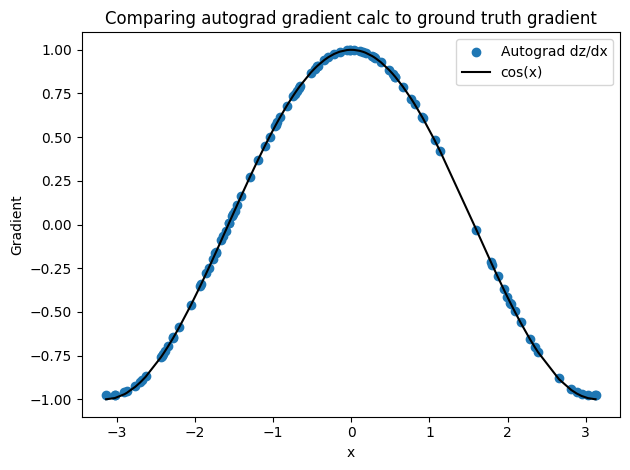

In [8]:
# 1d

# Using the same variables from 1c
dzdx = x.grad.cpu().numpy()

plt.figure()
plt.scatter(x_npy, dzdx, label="Autograd dz/dx")
plt.plot(np.sort(x_npy), np.cos(np.sort(x_npy)), label="cos(x)", color='black')
plt.xlabel("x")
plt.ylabel("Gradient")
plt.title("Comparing autograd gradient calc to ground truth gradient")
plt.legend()
plt.tight_layout()
plt.show()


### Problem 1.2: Image Denoising

In [9]:
"""
Returns the x and y gradient images for input image I.
Input:
I: (Tensor) Image of shape (H, W, 3)

Output:
(Ix, Iy): (Tensor) Gradient images each of shape (H, W, 3)
"""
def get_spatial_gradients(I):
  I = I.permute(2, 0, 1).unsqueeze(0) # Change I's shape from (H, W, 3) to (1, 3, H, W)
  kx = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)
  ky = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)

  for i in range(3):
    kx[i, i, 1, 1] = -1
    kx[i, i, 1, 2] = 1
    ky[i, i, 1, 1] = -1
    ky[i, i, 2, 1] = 1

  Ix = F.conv2d(I, kx, padding=1)
  Iy = F.conv2d(I, ky, padding=1)
  return Ix[0,...].permute(1,2,0), Iy[0,...].permute(1,2,0)

"""
Denoising objective function.
Input:
I, J: (Tensor) Images of shape (H, W, 3)
alpha: (float) Regularization hyperparameter

Output:
loss: (Tensor[float])
"""
def denoising_loss(I, J, alpha):
  dxJ, dyJ = get_spatial_gradients(J)
  return torch.norm(I-J, p=1) + alpha*( torch.norm(dxJ, p=1) + torch.norm(dyJ, p=1))

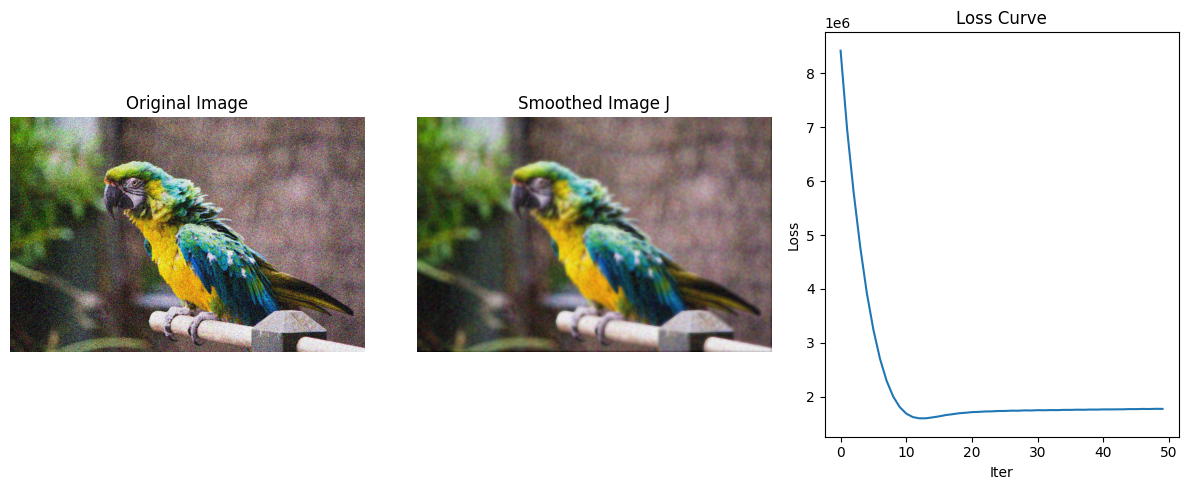

In [10]:
img = imageio.imread('/content/drive/My Drive/ELEC546/HW4/parrot_noisy.png') / 255.0
I = torch.tensor(img, dtype=torch.float32)
I = I.to(device)

lr = 0.001 # Learning rate
alpha = 10.0 # alpha
n_iter = 50 # Number of iterations

# Initialize J to be a copy of I, with gradients
J = I.clone().detach().requires_grad_(True)
loss_log = [0]*n_iter
for i in range(n_iter):
  loss = denoising_loss(I, J, alpha)
  loss_log[i] = loss.item()
  loss.backward()
  with torch.no_grad():
    J -= lr * J.grad
    J.grad.zero_()
# Detach and move result to CPU for plotting
J_img = J.detach().cpu().squeeze()

plt.figure(figsize=(12, 5))
# Original image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
# Smoothed image
plt.subplot(1, 3, 2)
plt.imshow(np.clip(J_img.numpy(), 0.0, 1.0), cmap='gray')
plt.title("Smoothed Image J")
plt.axis('off')
# Loss curve
plt.subplot(1, 3, 3)
plt.plot(loss_log)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

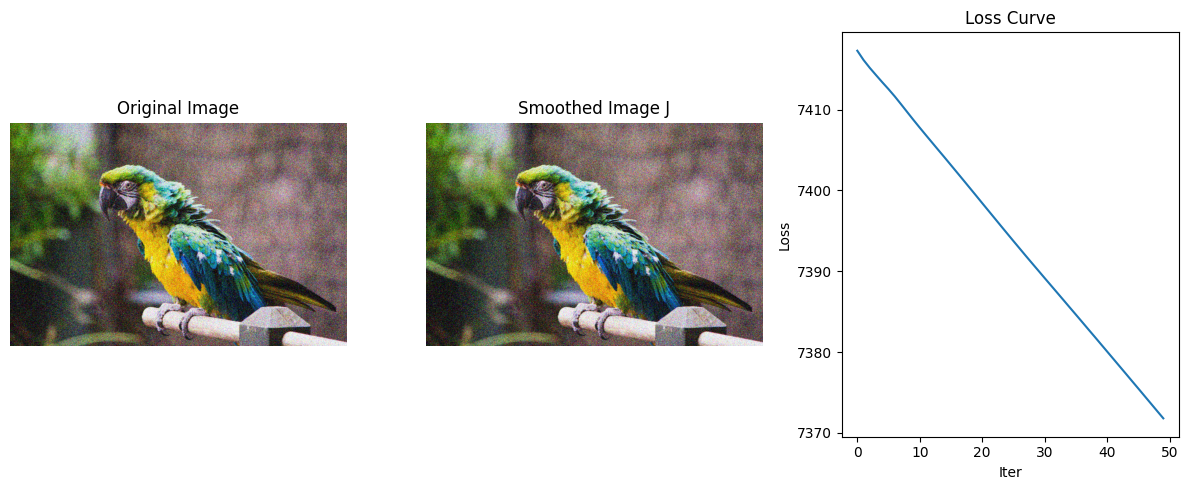

In [11]:
# 1.2c

def denoising_loss_L2(I, J, alpha):
  dxJ, dyJ = get_spatial_gradients(J)
  return torch.norm(I-J, p=2) + alpha*( torch.norm(dxJ, p=2) + torch.norm(dyJ, p=2))

I = torch.tensor(img, dtype=torch.float32)
I = I.to(device)

lr = 0.001 # Learning rate
alpha = 10.0 # alpha
n_iter = 50 # Number of iterations

# Initialize J to be a copy of I, with gradients
J = I.clone().detach().requires_grad_(True)
loss_log = [0]*n_iter
for i in range(n_iter):
  loss = denoising_loss_L2(I, J, alpha)
  loss_log[i] = loss.item()
  loss.backward()
  with torch.no_grad():
    J -= lr * J.grad
    J.grad.zero_()
# Detach and move result to CPU for plotting
J_img = J.detach().cpu().squeeze()

plt.figure(figsize=(12, 5))
# Original image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
# Smoothed image
plt.subplot(1, 3, 2)
plt.imshow(np.clip(J_img.numpy(), 0.0, 1.0), cmap='gray')
plt.title("Smoothed Image J")
plt.axis('off')
# Loss curve
plt.subplot(1, 3, 3)
plt.plot(loss_log)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

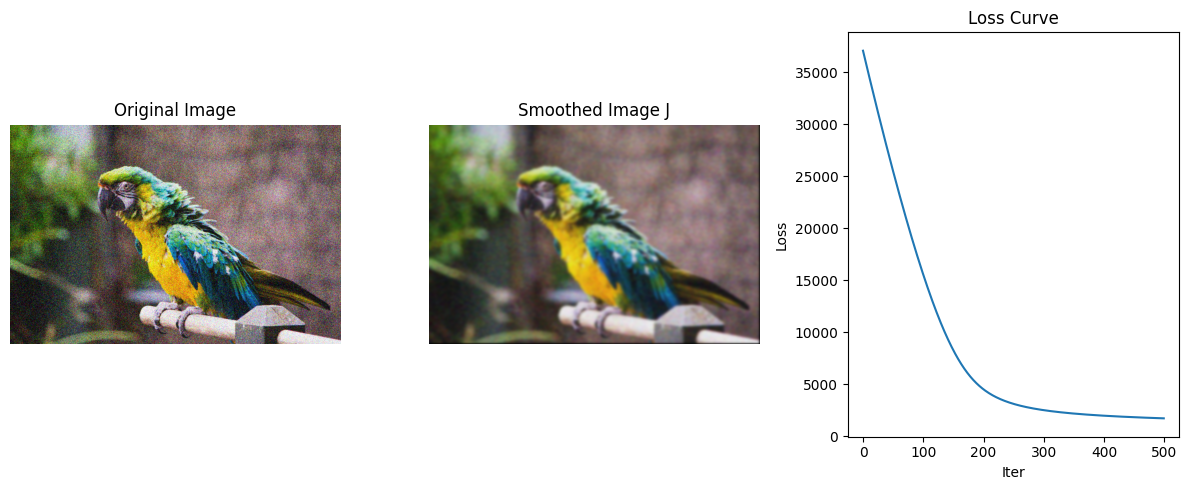

In [12]:
I = torch.tensor(img, dtype=torch.float32)
I = I.to(device)

lr = 0.01 # Learning rate
alpha = 50.0 # alpha
n_iter = 500 # Number of iterations

# Initialize J to be a copy of I, with gradients
J = I.clone().detach().requires_grad_(True)
loss_log = [0]*n_iter
for i in range(n_iter):
  loss = denoising_loss_L2(I, J, alpha)
  loss_log[i] = loss.item()
  loss.backward()
  with torch.no_grad():
    J -= lr * J.grad
    J.grad.zero_()
# Detach and move result to CPU for plotting
J_img = J.detach().cpu().squeeze()

plt.figure(figsize=(12, 5))
# Original image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
# Smoothed image
plt.subplot(1, 3, 2)
plt.imshow(np.clip(J_img.numpy(), 0.0, 1.0), cmap='gray')
plt.title("Smoothed Image J")
plt.axis('off')
# Loss curve
plt.subplot(1, 3, 3)
plt.plot(loss_log)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In my opinion, L2 is much worse. Basically, you can see that it did not work with the same hyperparameters as L1 (not that suprising), but the set of hyperparameters I found that worked 1) don't work that well and 2) are much slower to train (require many more iterations).

## Problem 2: Training an Image Classifier

### 2a: Finish implementing dataset class

In [13]:
class CIFARDataset(Dataset):
  def __init__(self, images, labels, mode, transform):
    self.transform = transform

    if mode == 'train':
      # Your code here. If training, use examples [0,40000) of the entire dataset
      self.images = images[0:40000]
      self.labels = labels[0:40000]

    elif mode == 'val':
      # Your code here. If validation, use examples [40,000-50,000) of the entire dataset
      self.images = images[40000:50000]
      self.labels = labels[40000:50000]

    elif mode == 'test':
      # Your code here. If testing, use examples [50,000-60,000) of the entire dataset
      self.images = images[50000:60000]
      self.labels = labels[50000:60000]

    else:
      raise ValueError('Invalid mode!')

  def __getitem__(self, idx):
    # Do the following:
    # 1. Get the image and label from the dataset corresponding to index idx.
    image = self.images[idx]
    label = self.labels[idx]
    # 2. Convert the label to a LongTensor (needs to be of this type because it
    # is an integer value and PyTorch will throw an error otherwise)
    label = torch.tensor(label, dtype=torch.long)
    # 3. Transform the image using self.transform. This will convert the image
    # into a tensor, scale it to [0,1], and apply data augmentations.
    if self.transform is not None:
        image = self.transform(image)
    # 4. Return the image and label.
    return image, label

  def __len__(self):
    return len(self.images)

### 2b: Write transforms

In [14]:
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, RandomAffine, ColorJitter

cifar = np.load('/content/drive/MyDrive/ELEC546/HW4/CIFAR.npz')
X, y, label_names = cifar['X'], cifar['y'] * 1.0, cifar['label_names']
print("Read in CIFAR10 dataset with %d examples, and labels:\n %s" % (X.shape[0], label_names))

batch_size = 64

transform = Compose([
    ToTensor(),
    RandomHorizontalFlip(),
    RandomAffine(degrees=5, scale=(0.8, 1.2)),
    ColorJitter(brightness=(0.8, 1.2), saturation=(0.8, 1.2))
])
train_dataset = CIFARDataset(X, y, "train", transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = Compose([ToTensor()])
val_dataset = CIFARDataset(X, y, "val", transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = Compose([ToTensor()])
test_dataset = CIFARDataset(X, y, "test", transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Read in CIFAR10 dataset with 60000 examples, and labels:
 ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


### 2c: Implement the model

In [15]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    # Have to use padding otherwise kernel_size is too big
    self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(100, 100, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(100, 100, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(100 * 4 * 4, 100)  # This is hardcoded in, but that's fine I think since the model isn't dynamic (can only be resized manually)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.pool(x)

    x = F.relu(self.conv4(x))

    x = x.view(x.size(0), -1)  # Flatten to 2D, first dim is batchsize
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

### 2d/2e: Implement the training loop, and train your model.

In [16]:
# Your code here. Don't forget to call model.train() before training!

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import os

def train_model(model, train_dataset, val_dataset, save_dir, lr=1e-4, bs=64, num_epochs=15, device=device):
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        torch.save(model.state_dict(), os.path.join(save_dir, f'2e_model_epoch_{epoch+1}.pth'))

    return val_losses


In [17]:
# 2e

model = Model()
val_losses = train_model(model, train_dataset, val_dataset, save_dir='/content/drive/MyDrive/ELEC546/HW4/checkpoints')


Epoch 1, Training Loss: 1191.8920
Epoch 1, Validation Loss: 1.7195
Epoch 2, Training Loss: 1035.5085
Epoch 2, Validation Loss: 1.5824
Epoch 3, Training Loss: 978.8438
Epoch 3, Validation Loss: 1.4777
Epoch 4, Training Loss: 927.3545
Epoch 4, Validation Loss: 1.4024
Epoch 5, Training Loss: 891.9173
Epoch 5, Validation Loss: 1.3510
Epoch 6, Training Loss: 864.0557
Epoch 6, Validation Loss: 1.3187
Epoch 7, Training Loss: 840.1109
Epoch 7, Validation Loss: 1.2828
Epoch 8, Training Loss: 813.3844
Epoch 8, Validation Loss: 1.2325
Epoch 9, Training Loss: 793.4441
Epoch 9, Validation Loss: 1.2108
Epoch 10, Training Loss: 773.9180
Epoch 10, Validation Loss: 1.2543
Epoch 11, Training Loss: 756.0377
Epoch 11, Validation Loss: 1.1688
Epoch 12, Training Loss: 742.4577
Epoch 12, Validation Loss: 1.1480
Epoch 13, Training Loss: 724.1139
Epoch 13, Validation Loss: 1.1081
Epoch 14, Training Loss: 705.9933
Epoch 14, Validation Loss: 1.0829
Epoch 15, Training Loss: 696.7260
Epoch 15, Validation Loss: 1.0

### 2f: Choose the best model based on overall accuracy
using the validation dataset.

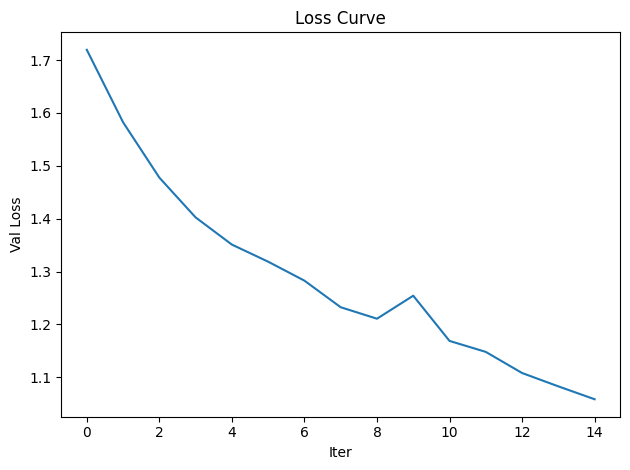

In [18]:
# I just eval the model inside the training loop since that's how I normally do it...
## So, just plotting the results here:

plt.figure()
plt.plot(val_losses)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Val Loss")
plt.tight_layout()
plt.show()

I choose the last model because it has the lowest validation loss. The model appears to not have overfit at all. The validation loss has not plateaued yet

### 2g: Implement code for computing overall accuracy, accuracy per class, and the confusion matrix on the test set.

Overall accuracy: 0.6322

airplane accuracy: 71.20%
automobile accuracy: 72.19%
bird accuracy: 45.90%
cat accuracy: 45.08%
deer accuracy: 59.88%
dog accuracy: 57.07%
frog accuracy: 61.53%
horse accuracy: 70.83%
ship accuracy: 81.46%
truck accuracy: 66.44%



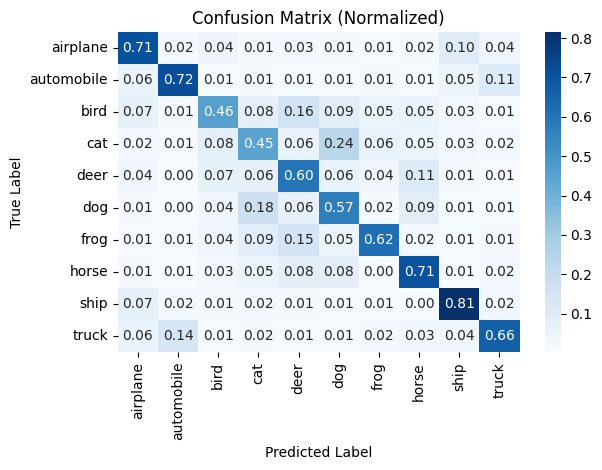

In [23]:
# Your code here. Don't forget to call model.eval() first!

#device = "cuda"
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load in model 15
model = Model().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/ELEC546/HW4/checkpoints/2e_model_epoch_15.pth'))
model.eval()

# Calc overall accuracy
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()
model.eval()
val_loss = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
avg_val_loss = val_loss / len(val_loader)
val_losses.append(avg_val_loss)

correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

overall_accuracy = correct / total
print(f"Overall accuracy: {overall_accuracy:.4f}")
print()

# Calc accuracy per class
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
per_class_acc = []
for i in range(len(class_names)):
    correct_i = np.sum((all_preds == i) & (all_labels == i))
    total_i = np.sum(all_labels == i)
    acc_i = correct_i / total_i
    per_class_acc.append(acc_i)
    print(f"{class_names[i]} accuracy: {(acc_i*100):.2f}%")
print()

# Create the confusion matrix (10x10)
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure()
sns.heatmap(conf_mat, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

In [25]:
# For the class with the worst accuracy, what class is it most often confused with? Show 5-10 test images and comment on similarities

# Find the class with worst accuracy
worst_class_idx = np.argmin(per_class_acc)
worst_class = class_names[worst_class_idx]

# Find the most confused class
# Find the largest index first (this is the correct prediction rate for the already identified worst class)
largest_idx = np.argmax(conf_mat[worst_class_idx, :])
# Mask the largest value so it won't be considered
masked_conf_mat = np.copy(conf_mat[worst_class_idx, :])
masked_conf_mat[largest_idx] = -np.inf
# Now find the second-largest index (ie the prediction rate on the 2nd highest class, which is an incorrect class)
confused_with_idx = np.argmax(masked_conf_mat)

confused_with_class = class_names[confused_with_idx]
print(f"Worst performing class: {worst_class}")
print(f"Most confused with: {confused_with_class}")


Worst performing class: cat
Most confused with: dog


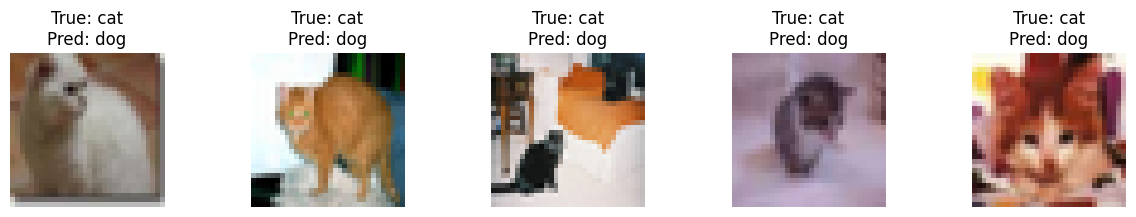

In [34]:
dog_for_cat_idx_lst = []
dog_for_cat_img_lst = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for idx, (img, lbl) in enumerate(zip(images, labels)):
          if lbl == worst_class_idx and preds[idx] == confused_with_idx:
            dog_for_cat_idx_lst.append(idx)
            dog_for_cat_img_lst.append(img)

# Plot up to 5 of them
num_to_show = min(len(dog_for_cat_img_lst), 5)
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 2))

for i in range(num_to_show):
    idx = dog_for_cat_idx_lst[i]
    img = dog_for_cat_img_lst[i]
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"True: {worst_class}\nPred: {confused_with_class}")
    axes[i].axis('off')

plt.show()


## Problem 3: Run Mask R-CNN with Detectron2

> 3.1: Conceptual: Mask R-CNN extends Faster R-CNN by adding a mask prediction branch. Explain the role of this branch and why it is necessary for instance segmentation.

Faster R-CNN can be broken up into stage 1: the backbone network and RPN that are run once per image and stage 2: crop/alignment, predicting object class, predicting box offsets that are run once per region. This allows Faster R-CNN to do relatively quick object detection and bounding, namely identifying objects and then drawing a box to locate them. Mask R-CNN has the same architecture, but with the addition of the mask prediction branch, which is necessary since Mask R-CNN has the goal of doing instance segmentation, i.e., classifying evvery pixel belonging to an object of interest, as opposed to Faster R-CNN's object detection which wraps a box around each object and states what object is in that box. Thus, Mask R-CNN has a more difficult task, as it must segment each individual pixel (within the identified region/box), which is an extra step from Faster R-CNN. The mask prediction branch is responsible for masking the pixels within each box in order to segment the actual object out from the background in its identified box. The mask prediction branch creates a binary mask for every single class within each box / region of interest, and this is what ultimately identifies the exact position of each object. Without the mask prediction branch, Mask R-CNN would be the exact same as Faster R-CNN.

In [ ]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).

import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
# import libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# load image
im = cv2.imread('/content/drive/My Drive/ELEC546/HW4/train.jpg')
cv2_imshow(im)

> 3.2 Try different model configurations (e.g., pre-trained weights, confidence thresholds).
Visualize the segmentation results with at least three different threshold values. Explain
how changing the threshold affects the results in terms of detected objects, false positives
(incorrect detections), and false negatives (missing detections). Discuss how you would
handle this precision-recall tradeoff in different real-world applications.

In [ ]:
# Load pre-trained model
# You can find the model cofig from the following url, or other config of your choice
# https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-Detection
# https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-InstanceSegmentation

##### Your code #####
MY_YAML = 'COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml'
# 'COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml'
# 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
# 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
# 'COCO-Detection/rpn_R_50_C4_1x.yaml'
# 'COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml'
THRESHOLD = 0.5

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MY_YAML))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MY_YAML)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD  # set threshold for this model (0-1)

In [ ]:
# Create predictor
predictor = DefaultPredictor(cfg)
# Run inference on the sample image
outputs = predictor(im)

In [ ]:
# Visualize results with "Visualizer"
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Problem 4: Adversarial attacks for trained networks. Wite code below

In [ ]:
#import torch.nn.functional as F

def fgsm_attack(model, image, label, eps):
    image = image.clone().detach().requires_grad_(True)
    label = label.clone().detach()
    criterion = nn.CrossEntropyLoss()

    model.eval()
    output = model(image)
    #loss = F.cross_entropy(output, label)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()

    # Generate adversarial image
    perturbation = eps * image.grad.data.sign()
    adv_image = image + perturbation
    adv_image = torch.clamp(adv_image, 0, 1)  # Keep in [0, 1] range

    return adv_image.detach(), perturbation.detach()


In [ ]:
# Your code here for creating and displaying adversarial images.

def show_attack_result(model, image, label, eps, class_names, device=device):
    image = image.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    # Predict original
    model.eval()
    pred_orig = model(image).argmax(dim=1).item()

    # Apply FGSM
    adv_image, perturbation = fgsm_attack(model, image, label, eps)

    # Predict adversarial
    pred_adv = model(adv_image).argmax(dim=1).item()

    # Convert to CPU for plotting
    ## Reorder height width and channels to be what matplotlib will expect when plotting
    img_orig = image.squeeze().cpu().permute(1, 2, 0).numpy()
    img_pert = perturbation.squeeze().cpu().permute(1, 2, 0).numpy()
    img_adv = adv_image.squeeze().cpu().permute(1, 2, 0).numpy()

    # Scale perturbation visually
    vis_pert = img_pert * 10 + 0.5  # exaggerate and center

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_orig)
    plt.title(f"Original\nPred: {class_names[pred_orig]}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(vis_pert)
    plt.title("Perturbation (×10)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_adv)
    plt.title(f"Adversarial\nPred: {class_names[pred_adv]}")
    plt.axis('off')

    plt.suptitle(f"FGSM Attack (ε = {eps})", fontsize=16)
    plt.tight_layout()
    plt.show()
